In [165]:
Threads.nthreads()

4

## Max-Sum

In [172]:
include("../code/rs_gfq.jl")
ProgressMeter.ijulia_behavior(:clear)

false

In [83]:
function rand_msg(Q::Int, noise::Real)
    v = SVector{Q}(noise*randn(Q))
    v .- maximum(v)
end
function rand_msg2(Q::Int, J::Int)
    @assert Q==2
    j = float(rand(-J:J)) 
    m = SVector{2}(0, j)
    m .- maximum(m)
end
function rand_msgQ(Q::Int, J::Int)
    js = float.(rand(-J:J,Q))
    m = SVector{Q}(js)
    m .- maximum(m)
end   

rand_msgQ (generic function with 1 method)

In [121]:
Q = 2
gfmult, gfdiv = gftables(Val(Q))
N = 2*10^5
maxiter = 20
Λ = [0,1]; maxd = findlast(!iszero, Λ)
Pk = [0,0,0,0,0,01]; maxk = findlast(!iszero, Pk)
mK = sum(k*Pk[k] for k=eachindex(Pk)); mΛ = sum(d*Λ[d] for d=eachindex(Λ))
R=1-mΛ/mK
# popP = fill(zero(SVector{Q}), N)
# popQ = fill(zero(SVector{Q}), N);

In [122]:
popP = [rand_msg2(Q, maxk) for _ in 1:N]
popQ = [rand_msg2(Q, maxk) for _ in 1:N];

In [123]:
err = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, showprogress=false)

(avgP_old, avgP) = ([-1.6161, -1.61426], [-0.52828, -0.52884])
(avgP_old, avgP) = ([-0.52828, -0.52884], [-0.1644, -0.164325])
(avgP_old, avgP) = ([-0.1644, -0.164325], [-0.212615, -0.21327])
(avgP_old, avgP) = ([-0.212615, -0.21327], [-0.15132, -0.152305])
(avgP_old, avgP) = ([-0.15132, -0.152305], [-0.217115, -0.21824])
(avgP_old, avgP) = ([-0.217115, -0.21824], [-0.1472, -0.1482])
(avgP_old, avgP) = ([-0.1472, -0.1482], [-0.223185, -0.22392])
(avgP_old, avgP) = ([-0.223185, -0.22392], [-0.14314, -0.141835])
(avgP_old, avgP) = ([-0.14314, -0.141835], [-0.233915, -0.232895])
(avgP_old, avgP) = ([-0.233915, -0.232895], [-0.133065, -0.135505])
(avgP_old, avgP) = ([-0.133065, -0.135505], [-0.241405, -0.24123])
(avgP_old, avgP) = ([-0.241405, -0.24123], [-0.125235, -0.125315])
(avgP_old, avgP) = ([-0.125235, -0.125315], [-0.25647, -0.258345])
(avgP_old, avgP) = ([-0.25647, -0.258345], [-0.114815, -0.114935])
(avgP_old, avgP) = ([-0.114815, -0.114935], [-0.273375, -0.27368])
(avgP_old, avg

0.248965

In [74]:
Pk = [0,0,0,0,1]
mK = sum(k*Pk[k] for k=eachindex(Pk))
R=1-mΛ/mK;

In [75]:
err = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
  it:   20
  err:  0.22787/0.00447213595499958


0.22787

In [87]:
include("../code/rs.jl")
R_rs, D_rs, P_rs, Q_rs = RS(Pk, Λ; N=10^3, tol=1e-5, maxiter=10^3, damp=0.9);
D_rs

err = 9.745257657955975e-6
iter = 136
Fia = -2.0043662710229317
Fi = 1.0859382039294192
Fa = 0.12961376906606734


0.10559285098627741

In [88]:
F = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  it:  100000
  F:   0.10742199999999998


0.10742199999999998

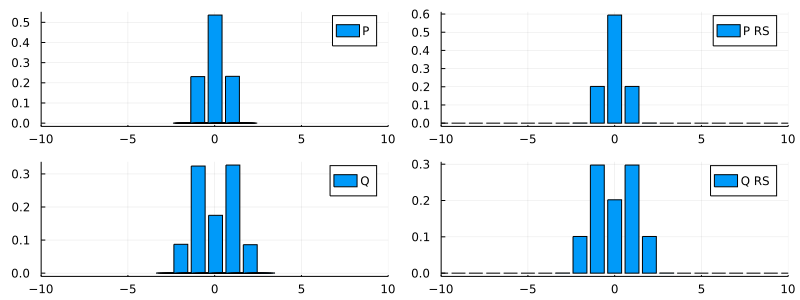

In [89]:
Pavg = [(p[1]-p[2]) for p in popP]
Qavg = [(p[1]-p[2]) for p in popQ]
p1 = histogram(Pavg, label="P", normalize=:probability, barwidths=.8)
xlims!(p1, (-10,10))
p2 = histogram(Qavg, label="Q", normalize=:probability, barwidths=.8)
xlims!(p2, (-10,10))
J = lastindex(P_rs)
p3 = bar(-J:J, P_rs.parent, label="P RS")
xlims!(p3, (-10,10))
p4 = bar(-J:J, Q_rs.parent, label="Q RS")
xlims!(p4, (-10,10))
p1 = plot(p1,p3, p2, p4, layout=(2,2), size=(800,300))

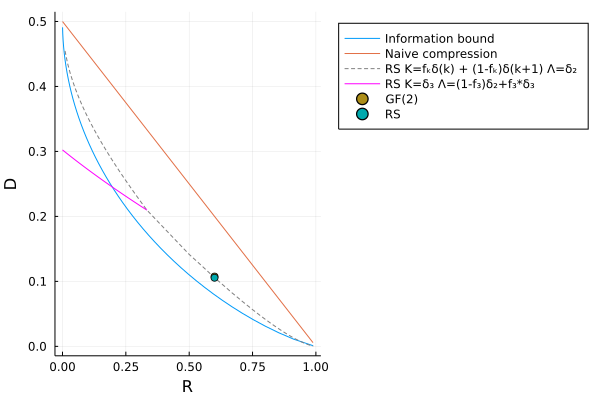

In [90]:
plot_rdb()
scatter!([R], [F], legend=:outertopright, label="GF($Q)")
scatter!([R_rs], [D_rs], legend=:outertopright, label="RS")

### Monitor the distortion

In [177]:
Q = 2
gfmult, gfdiv = gftables(Val(Q))
N = 10^5
maxiter = 2
Λ = [0,1]; maxd = findlast(!iszero, Λ)
Pk = [0,0,0,0,0,0,0,0,0,0,1]; maxk = findlast(!iszero, Pk)
mK = sum(k*Pk[k] for k=eachindex(Pk)); mΛ = sum(d*Λ[d] for d=eachindex(Λ))
R=1-mΛ/mK
popP = [rand_msg2(Q, maxk+1) for _ in 1:N]
popQ = [rand_msg2(Q, maxk+1) for _ in 1:N]

M = 20
errs = fill(NaN, M+1); 
ds = fill(NaN, M+1); ds[1] = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5, showprogress=false)
X = maxiter * (0:M)
Pfield = fill(zeros(N), M+1); Pfield[1] = [(p[1]-p[2]) for p in popP]
Qfield = fill(zeros(N), M+1); Qfield[1] = [(p[1]-p[2]) for p in popQ];

In [178]:
@showprogress for j in 1:M
    errs[j+1] = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, showprogress=false)
    ds[j+1] = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5, showprogress=false)
    Pfield[j+1] .= [(p[1]-p[2]) for p in popP]
    Qfield[j+1] .= [(p[1]-p[2]) for p in popQ]
end

Iter 1 of 20:  

Progress:   5%|██                                       |  ETA: 0:01:36

Iter 2 of 20:  

Progress:  10%|████▏                                    |  ETA: 0:01:31

Iter 3 of 20:  

Progress:  15%|██████▏                                  |  ETA: 0:01:26

Iter 4 of 20:  

Progress:  20%|████████▎                                |  ETA: 0:01:20

Iter 5 of 20:  

Progress:  25%|██████████▎                              |  ETA: 0:01:15

Iter 6 of 20:  

Progress:  30%|████████████▎                            |  ETA: 0:01:10

Iter 7 of 20:  

Progress:  35%|██████████████▍                          |  ETA: 0:01:03

Iter 8 of 20:  

Progress:  40%|████████████████▍                        |  ETA: 0:00:56

Iter 9 of 20:  

Progress:  45%|██████████████████▌                      |  ETA: 0:00:51

Iter 10 of 20:  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:45

Iter 11 of 20:  

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:40

Iter 12 of 20:  

Progress:  60%|████████████████████████▋                |  ETA: 0:00:35

Iter 13 of 20:  

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:30

Iter 14 of 20:  

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:26

Iter 15 of 20:  

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:21

Iter 16 of 20:  

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:17

Iter 17 of 20:  

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:13

Iter 18 of 20:  

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:08

Iter 19 of 20:  

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:04

Iter 20 of 20:  

Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


┌ Info: Saved animation to 
│   fn = /home/crotti/sourcecoding/notebooks/tmp.gif
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/home/crotti/sourcecoding/notebooks/tmp.gif")
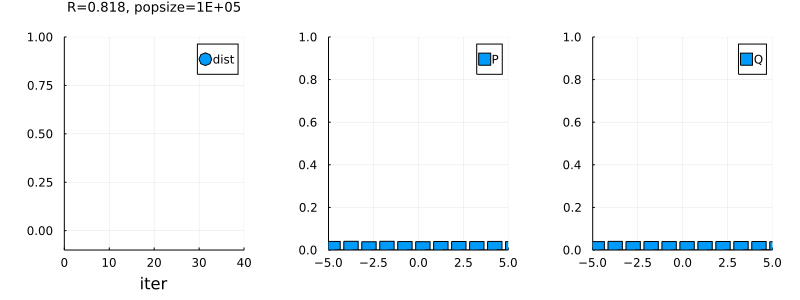

In [179]:
anim = @animate for j in 1:M
    p1 = plot(X[1:j], ds[1:j], label="dist", xlabel="iter", m=:o, size=(400,200))
    title!(p1, "R=$(round(R,digits=3)), popsize="*(@sprintf("%.0E", N)), titlefontsize=9)
    xlims!(p1, extrema(X)); ylims!(p1, (-0.1,1))
    j !=1 && plot!(p1, X[1:j], errs[1:j], label="error", xlabel="iter", m=:o)
    p2 = histogram(Pfield[j], normalize=:probability, label="P", barwidths=.8, xlims=(-5,5), ylims=(0,1))
    p3 = histogram(Qfield[j], normalize=:probability, label="Q", barwidths=.8, xlims=(-5,5), ylims=(0,1))
    plot(p1,p2,p3, layout=(1,3), size=(800,300), margin=5Plots.mm)
end
gif(anim, "/home/crotti/sourcecoding/notebooks/tmp.gif", fps=3)

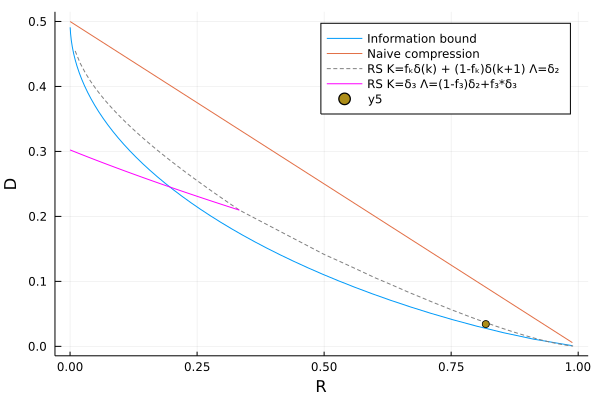

In [180]:
plot_rdb()
scatter!([R], [mean(ds[end÷2:end])])

## Varying q

In [284]:
Qs = [2,4,8,16]
N = 10^5
Λ = [0,1.0]; maxd = findlast(!iszero, Λ)
Pk = [0,0,1]; maxk = findlast(!iszero, Pk)
mK = sum(k*Pk[k] for k=eachindex(Pk))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
R = 1 - mΛ/mK
maxiter = 20
ds = zeros(length(Qs))
errs = zeros(length(Qs));

In [285]:
for (i,Q) in enumerate(Qs)
    gfmult, gfdiv = gftables(Val(Q))
    popP = [rand_msgQ(Q, maxd) for _ in 1:N]
    popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]
    errs[i] = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter)
    F = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5)
    ds[i] = F
end
errs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  it:  100000
  F:   0.18370833333333328


F = 0.18370833333333328


4-element Vector{Float64}:
 0.010909999999999975
 0.007999999999999896
 0.008560000000000012
 0.010099999999999998

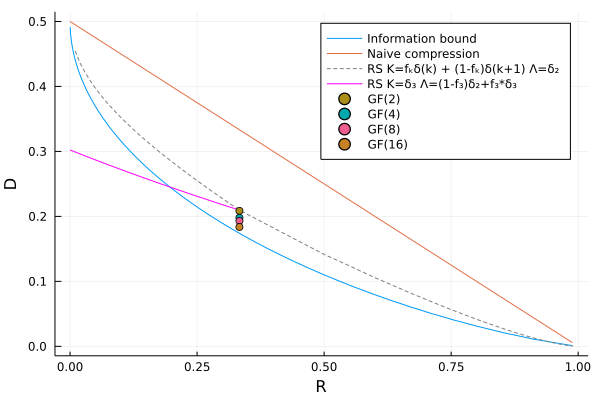

In [287]:
pl = plot_rdb()
for (i,Q) in enumerate(Qs)
    scatter!(pl, [R], ds[i:i], label="GF($Q)")
end
pl

## Varying rate

In [ ]:
Rs = 0.01:0.1:0.99 
ds = zeros(length(Rs))
errs = zeros(length(Rs))
Λ = [0,1]
Q = 2
N = 5*10^5
maxiter = 10
gfmult, gfdiv = gftables(Val(Q))
@showprogress for (i,r) in enumerate(Rs)
#     println("### R=$r")
    α=1-r
    k=floor(Int, 2/α)
    s=k+1-2/α
    Pk=[fill(0,k-1); s; 1-s]
    Pk .*= Pk .> 1e-10
    Pk ./= sum(Pk)
    maxk = findlast(!iszero, Pk); maxd = findlast(!iszero, Λ)
    popP = [rand_msgQ(Q, maxd) for _ in 1:N]
    popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]
    errs[i] = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, showprogress=false)
    F = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5, showprogress=false)
    ds[i] = F
end

### R=0.01


Progress:  10%|████▏                                    |  ETA: 0:00:55

### R=0.11


Progress:  20%|████████▎                                |  ETA: 0:02:24

### R=0.21


Progress:  30%|████████████▎                            |  ETA: 0:02:36

### R=0.31


Progress:  40%|████████████████▍                        |  ETA: 0:02:29

### R=0.41


Progress:  50%|████████████████████▌                    |  ETA: 0:02:14

### R=0.51


Progress:  60%|████████████████████████▋                |  ETA: 0:01:54

In [ ]:
p = plot_rdb()
plot!(p, Rs, ds, label="GF(2)", ms=3, m=:circle)

In [28]:
Rs = 0.01:0.05:0.99 
ds2 = zeros(length(Rs))
errs2 = zeros(length(Rs))
Λ = [0,1]
Q = 4
N = 10^6
maxiter = 2
navg = 4
gfmult, gfdiv = gftables(Val(Q))
@showprogress for (i,r) in enumerate(Rs)
    α=1-r
    k=floor(Int, 2/α)
    s=k+1-2/α
    Pk=[fill(0,k-1); s; 1-s]
    Pk .*= Pk .> 1e-10
    Pk ./= sum(Pk)
    popP = [rand_msgQ(Q, maxd) for _ in 1:N]
    popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]
    e = zeros(navg); d = zeros(navg);
    for j in 1:navg
        e[j] = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, showprogress=false)
        d[j] = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5, showprogress=false)
    end
    errs2[i] = mean(e[navg÷2:end]); ds2[i] = mean(d[navg÷2:end])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:53:05


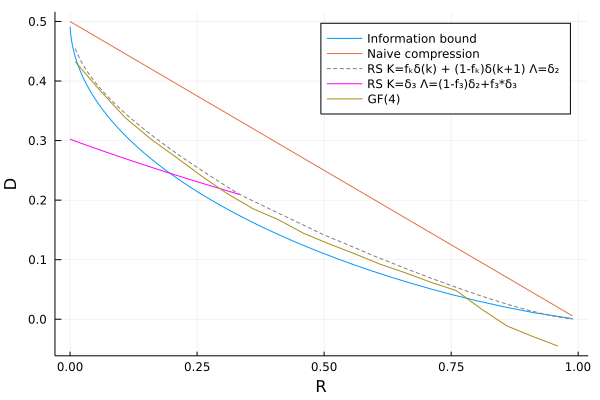

In [29]:
plot!(plot_rdb(), Rs, ds2, label="GF(4)")

In [367]:
Rs = 0.01:0.05:0.99 
ds3 = zeros(length(Rs))
errs3 = zeros(length(Rs))
Λ = [0,1]
Q = 8
N = 10^6
maxiter = 6
gfmult, gfdiv = gftables(Val(Q))
for (i,r) in enumerate(Rs)
    println("### R=$r")
    α=1-r
    k=floor(Int, 2/α)
    s=k+1-2/α
    Pk=[fill(0,k-1); s; 1-s]
    Pk .*= Pk .> 1e-10
    Pk ./= sum(Pk)
    popP = [rand_msgQ(Q, maxd) for _ in 1:N]
    popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]
    errs3[i] = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter)
    F = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5)
    ds3[i] = F
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
  it:  100000
  F:   -0.0036589333333333102


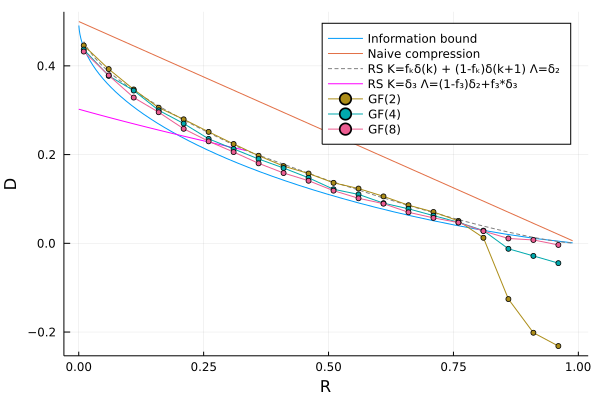

In [368]:
plot!(p, Rs, ds3, label="GF(8)", ms=3, m=:circle)

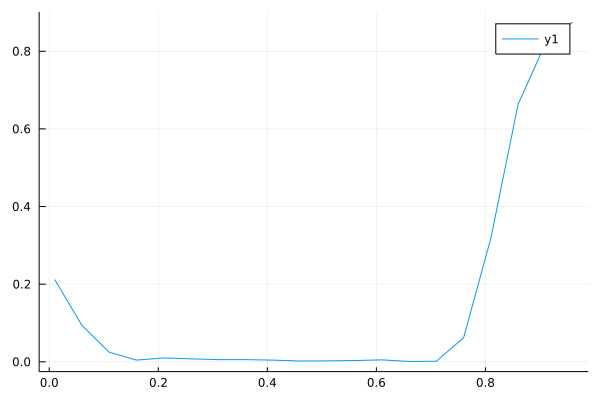

In [386]:
plot(Rs, errs3)